## Imports

In [3]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
import scipy 
from numba import njit, prange
from pyccel.epyccel import epyccel
from pyccel.decorators import types
import subprocess
import os
import shutil
import sys
import re
import pytest
import time
import time

## Pure python function

In [11]:
def solve_2d_linearconv_pure(u, un, nt, dt, dx, dy, c):
   
 
 for n in range(nt + 1): ##loop across number of time steps
    un = u.copy()
    row, col = u.shape
    for j in range(1, row):
        for i in range(1, col):
            u[j, i] = (un[j, i] - (c * dt / dx * (un[j, i] - un[j, i - 1])) -
                                  (c * dt / dy * (un[j, i] - un[j - 1, i])))
            u[0, :] = 1
            u[-1, :] = 1
            u[:, 0] = 1
            u[:, -1] = 1               
    return 0

## Numba accelerator

In [38]:
@njit(parallel=True , fastmath=True)
def solve_2d_linearconv_numba(u, un, nt, dt, dx, dy, c):
   
 for n in prange(nt + 1): ##loop across number of time steps
    un = u.copy()
    row, col = u.shape
    for j in prange(1, row):
        for i in prange(1, col):
            u[j, i] = (un[j, i] - (c * dt / dx * (un[j, i] - un[j, i - 1])) -
                                  (c * dt / dy * (un[j, i] - un[j - 1, i])))
            u[0, :] = 1
            u[-1, :] = 1
            u[:, 0] = 1
            u[:, -1] = 1    

    
               
    return 0

## Pyccel accelerator

In [29]:
@types('float[:,:]', 'float[:,:]','int','float','float','float','float')

def solve_2d_linearconv_pyccel(u, un, nt, dt, dx, dy, c):
   
   for n in range(nt + 1): ##loop across number of time steps
    un[:,:] = u[:,:]
    row, col = u.shape
    for j in range(1, row):
        for i in range(1, col):
            u[j, i] = (un[j, i] - (c * dt / dx * (un[j, i] - un[j, i - 1])) -
                                  (c * dt / dy * (un[j, i] - un[j - 1, i])))
            u[0, :] = 1
            u[-1, :] = 1
            u[:, 0] = 1
            u[:, -1] = 1    

    
               
    return 0

## Inputs

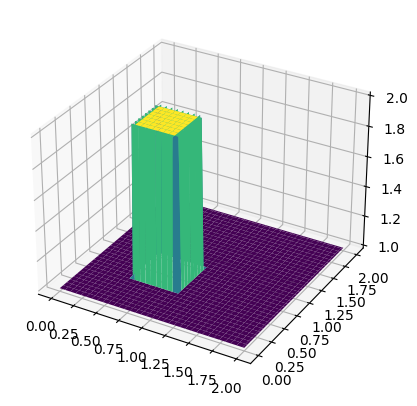

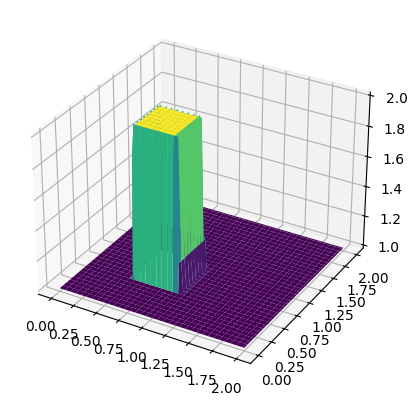

In [30]:
###variable declarations
nx = 101
ny = 101
nt = 100
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .2
dt = sigma * dx

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u0 = np.ones((ny, nx)) ##create a 1xn vector of 1's
u0[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
u = u0.copy()
un = np.ones((ny, nx)) 

solve_2d_linearconv_pure(u, un, nt, dt, dx, dy, c)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u0[:], cmap=cm.viridis)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(X, Y, u[:], cmap=cm.viridis)

## Call Funtions

### Pure function

In [31]:
%timeit solve_2d_linearconv_pure(u, un, nt, dt, dx, dy, c)

35.5 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Function with numba accelerator

In [39]:
%timeit solve_2d_linearconv_numba(u, un, nt, dt, dx, dy, c)

3.13 ms ± 75.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with pyccel accelerator

In [40]:
solve_2d_linearconv_f90 = epyccel(solve_2d_linearconv_pyccel)

In [41]:
%timeit solve_2d_linearconv_f90(u, un, nt, dt, dx, dy, c)

1.88 ms ± 27.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
